In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utilities import get_tex_label, get_color, latex_text_width_1col
from hazma.gamma_ray_parameters import energy_res_comptel
from hazma.vector_mediator import KineticMixing, QuarksOnly

**Plots annihilation spectra for the vector model in the case $m_\chi < m_V$.**

In [6]:
# Dark matter masses
mxs = np.array([100.0, 110.0, 140.0, 250.0])
# Mediator mass
mv = 1e3
# List of models. The top row of the plot will contain the Higgs portal model
# spectra, the bottom the heavy quark model spectra.
# Make array of models
vms = [
    KineticMixing(1.0, mv, gvxx=1.0, eps=0.1),
    QuarksOnly(1.0, mv, gvxx=1.0, gvuu=1.0, gvdd=-1.0, gvss=0.0),
    QuarksOnly(1.0, mv, gvxx=1.0, gvuu=1.0, gvdd=1.0, gvss=0.0),
]
# Approximate Milky Way velocity dispersion, used to compute the DM
# center of mass energy
vx_mw = 1e-3

# Photon energies
e_gam_min, e_gam_max = 5.0, 300
e_gams = np.geomspace(e_gam_min, e_gam_max, 250)

# Plot dimensions
n_subplot_rows, n_subplot_cols = len(vms), len(mxs)

# Label final states
fs_labels = np.array(
    [
        [{"e e": (1e1, 7e-3)}, {"mu mu": (7e0, 9e-5)}, {}, {"pi pi": (7e0, 3e-5)}],
        [{"pi0 g": (1.7e1, 1e-3)}, {}, {"pi pi": (1e1, 5e-3)}, {}],
        [{"pi0 g": (1.7e1, 1e-3)}, {}, {}, {}],
    ]
)

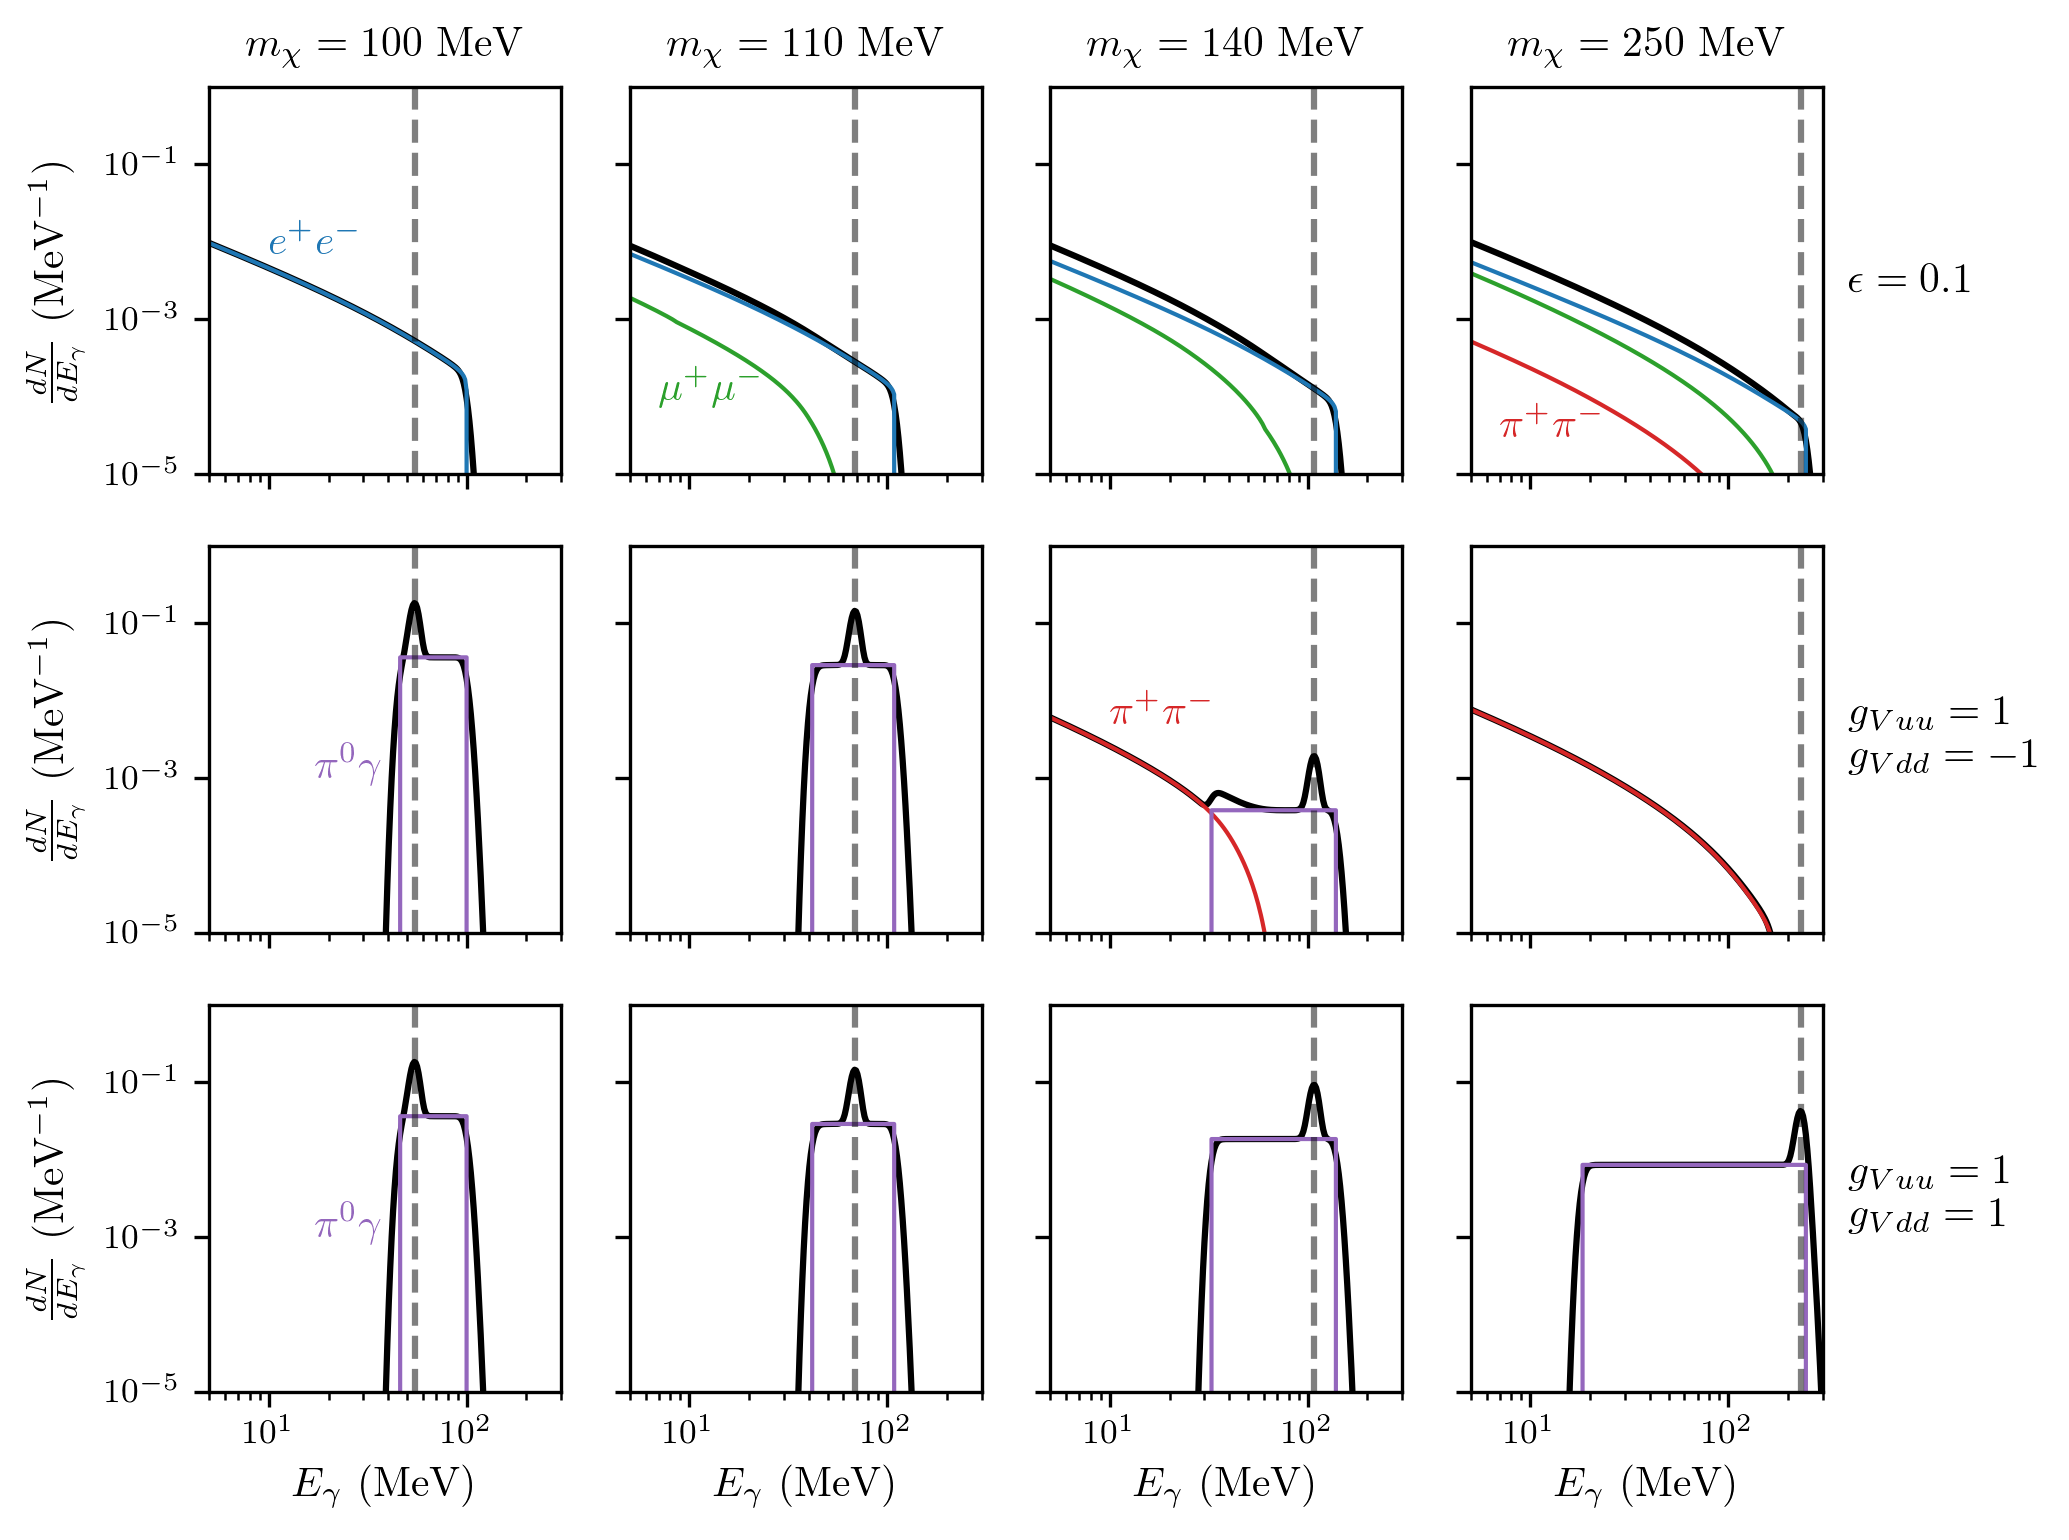

In [7]:
fig, axes = plt.subplots(
    n_subplot_rows,
    n_subplot_cols,
    sharex=True,
    sharey=True,
    figsize=(latex_text_width_1col, 0.75 * latex_text_width_1col),
)

for row in range(n_subplot_rows):  # loop over type of model
    for col in range(n_subplot_cols):  # loop over DM masses
        ax = axes[row, col]

        # Get the model and set DM mass to column's value
        vm = vms[row]
        vm.mx = mxs[col]
        # DM center of mass energy
        e_cm = 2.0 * vm.mx * (1.0 + 0.5 * vx_mw ** 2)

        # Get function to compute total convolved spectrum
        dnde_det_fn = vm.total_conv_spectrum_fn(
            e_gam_min, e_gam_max, e_cm, energy_res=energy_res_comptel
        )
        # Evaluate and plot
        ax.loglog(e_gams, dnde_det_fn(e_gams), "k")

        # Plot individual channels' continuum spectra
        for fs, spec in vm.spectra(e_gams, e_cm).items():
            if fs != "total":
                ax.loglog(e_gams, spec, color=get_color(fs), linewidth=1)

        # Compute line energies
        for fs, line_info in vm.gamma_ray_lines(e_cm).items():
            ax.axvline(
                line_info["energy"],
                linestyle="--",
                color="k",
                alpha=0.5,
                linewidth=1.5,
                label=r"$E_{\gamma\gamma}$",
            )

        # Formatting: label final states
        for fs, (x, y) in fs_labels[row, col].items():
            ax.text(x, y, get_tex_label(fs), fontsize=10, color=get_color(fs))

# Formatting
for row in range(n_subplot_rows):
    axes[row, 0].set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
    axes[row, 0].set_ylim(1e-5, 1e0)

for col in range(n_subplot_cols):
    axes[0, col].set_title(r"$m_\chi = %i$ MeV" % mxs[col], fontsize=10)
    axes[-1, col].set_xlabel(r"$E_\gamma$ (MeV)")
    axes[-1, col].set_xlim(e_gam_min, e_gam_max)

# Label couplings
axes[0, -1].text(400, 3e-3, r"$\epsilon = 0.1$", va="center", fontsize=10)
axes[1, -1].text(
    400, 3e-3, r"$g_{Vuu} = 1$" + "\n" + r"$g_{Vdd} = -1$", va="center", fontsize=10
)
axes[2, -1].text(
    400, 3e-3, r"$g_{Vuu} = 1$" + "\n" + r"$g_{Vdd} = 1$", va="center", fontsize=10
)

fig.tight_layout()
fig.savefig("figures/vector_spectra_ann_to_sm.pdf", bbox_inches="tight")
plt.show()